In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
#from my_data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box


In [2]:
def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    #ax.plot(point_squence.T[0] * 10 + 400, -point_squence.T[1] * 10 + 400, color=color)
    ax.plot(point_squence.transpose(0,1).numpy()[0] * 10 + 400, -point_squence.transpose(0,1).numpy()[1] * 10 + 400, color=color)

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)


transform = torchvision.transforms.ToTensor()


# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [4]:
sample, target, road_image, extra = iter(trainloader).next()
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 306])


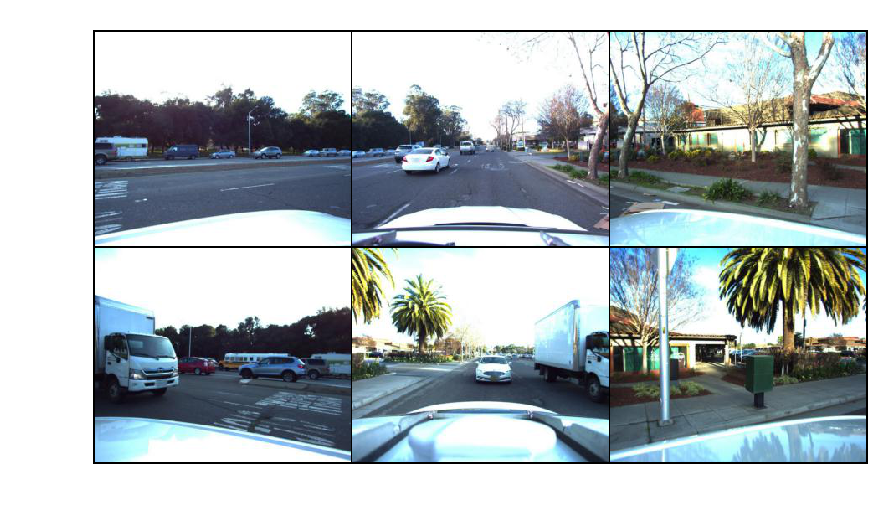

In [5]:
plt.imshow(torchvision.utils.make_grid(sample[0], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

In [10]:
device = 'cpu'

In [11]:
samples = torch.stack(sample).to(device)
print(samples.shape)
samples = samples.view(2, -1, 256, 306).to(device).double()
print(samples.shape)

torch.Size([2, 6, 3, 256, 306])
torch.Size([2, 18, 256, 306])


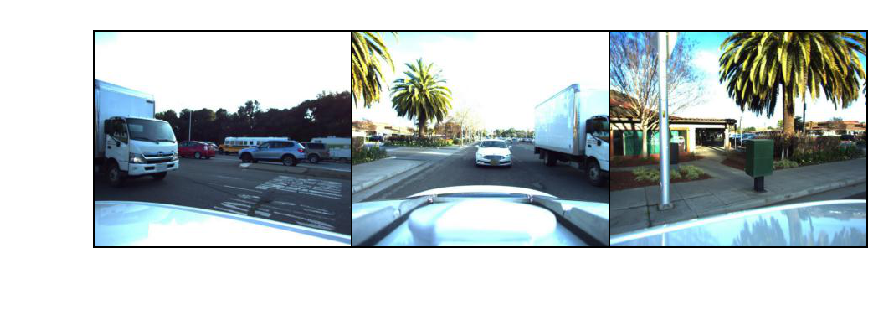

In [12]:
plt.imshow(torchvision.utils.make_grid(sample[0][3:6], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

In [13]:
# All bounding box are retangles
# Each bounding box is organized with four corners of the box
# All the values are in meter and bounded by 40 meters, and the origin is the center of ego car
# the order of the four courners are front left, front right, back left and back right
print(target[0]['bounding_box'])

tensor([[[ 13.2831,  13.3349,  17.8948,  17.9465],
         [ 25.8644,  27.5056,  25.7198,  27.3610]],

        [[ 14.3037,  14.2421,  10.1324,  10.0708],
         [  4.1931,   2.4533,   4.3401,   2.6002]],

        [[ 35.2930,  35.3207,  39.4124,  39.4402],
         [ 25.1107,  26.8744,  25.0466,  26.8103]],

        [[ 36.9403,  36.8914,  30.5231,  30.4741],
         [  4.2786,   2.1594,   4.4257,   2.3066]],

        [[ -3.6953,  -3.7594, -11.6718, -11.7359],
         [  5.7913,   3.2036,   5.9876,   3.3999]],

        [[ -5.1140,  -5.1125,  -0.3740,  -0.3726],
         [ 12.1262,  13.8881,  12.1230,  13.8849]],

        [[ 16.5970,  16.6660,  21.4289,  21.4978],
         [ 18.8616,  20.7673,  18.6878,  20.5934]],

        [[ 21.1648,  21.2943,  26.3547,  26.4842],
         [ 25.5365,  27.5181,  25.1985,  27.1801]],

        [[ -9.1118,  -9.1977, -13.1658, -13.2517],
         [  1.4267,  -0.3121,   1.6262,  -0.1126]],

        [[-15.7886, -13.9188, -17.1217, -15.2518],
         [ -9

In [14]:
print(target[0]['bounding_box'].shape)

torch.Size([19, 2, 4])


In [10]:
print(target[0]['category'])

tensor([2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 5, 2, 2, 0, 2, 2, 2, 2, 2])


In [11]:
print(target[0]['bounding_box'].shape)
print(target[0]['category'].shape)

torch.Size([19, 2, 4])
torch.Size([19])


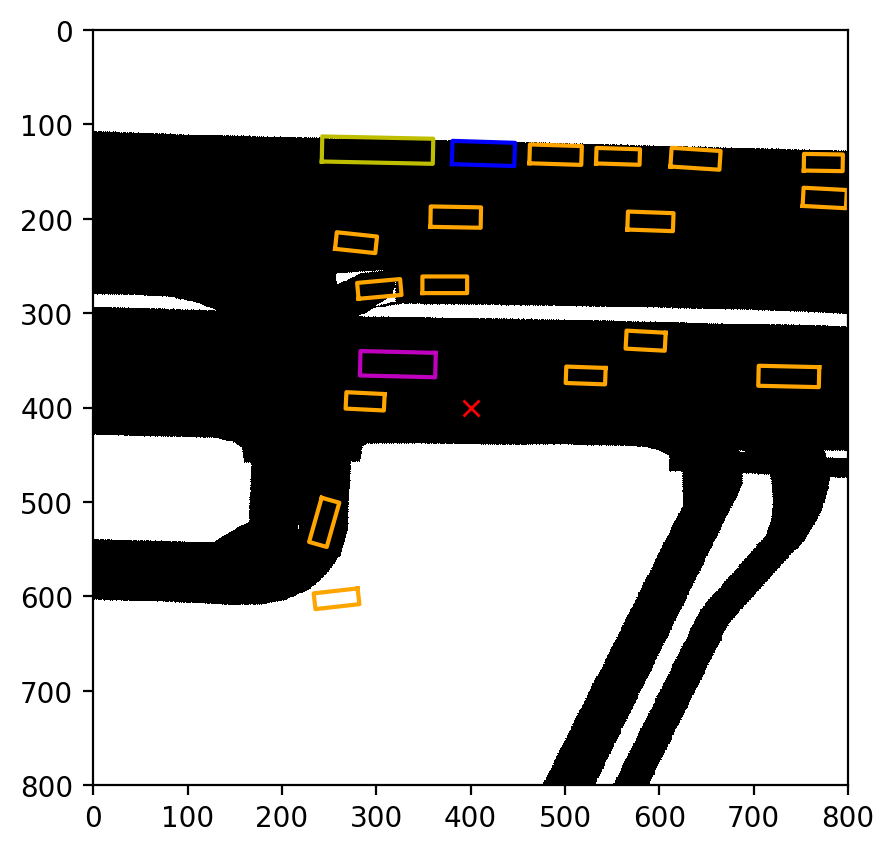

In [18]:
# The center of image is 400 * 400

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])

In [15]:
device = torch.device('cpu')


scaleX = [100, 70, 50, 20]
scaleY = [25, 20, 15, 5]
map_sz = 800


def get_gt_boxes():
    '''
    Return a matrix with size 4 x 2560000
    My guess: 2560000 = 800*800*4 -> since target BEV map of size 800*800, and each grid can store 4 coordinates? not sure
    '''
    widths = torch.tensor(scaleX)
    heights = torch.tensor(scaleY)
    ref_boxes = []
    for x in range(map_sz):
        for y in range(map_sz):
            x_r = widths + x
            y_r = heights + y
            x_l = torch.tensor([x, x, x, x])
            y_l = torch.tensor([y, y, y, y])
            x_r = x_r.unsqueeze(0)
            y_r = y_r.unsqueeze(0)
            x_l = x_l.unsqueeze(0)
            y_l = y_l.unsqueeze(0)
            ref_box = torch.cat((x_l, y_l, x_r, y_r))
            ref_box = ref_box.permute((1,0))
            ref_boxes.append(ref_box)

    gt_boxes = torch.stack(ref_boxes).view(-1,4).type(torch.double).to(device)
    return gt_boxes

In [16]:
gt_boxes = get_gt_boxes()

In [17]:
print(gt_boxes.shape)
print(gt_boxes[:10])
print(gt_boxes[10:])

torch.Size([2560000, 4])
tensor([[  0.,   0., 100.,  25.],
        [  0.,   0.,  70.,  20.],
        [  0.,   0.,  50.,  15.],
        [  0.,   0.,  20.,   5.],
        [  0.,   1., 100.,  26.],
        [  0.,   1.,  70.,  21.],
        [  0.,   1.,  50.,  16.],
        [  0.,   1.,  20.,   6.],
        [  0.,   2., 100.,  27.],
        [  0.,   2.,  70.,  22.]], dtype=torch.float64)
tensor([[  0.,   2.,  50.,  17.],
        [  0.,   2.,  20.,   7.],
        [  0.,   3., 100.,  28.],
        ...,
        [799., 799., 869., 819.],
        [799., 799., 849., 814.],
        [799., 799., 819., 804.]], dtype=torch.float64)


In [20]:
def get_offsets(gt_boxes, ex_boxes):

    ex_width = ex_boxes[:, 2] - ex_boxes[:, 0]
    ex_height = ex_boxes[:, 3] - ex_boxes[:, 1]
    ex_center_x = ex_boxes[:, 0] + 0.5*ex_width
    ex_center_y = ex_boxes[:, 1] + 0.5*ex_height

    gt_width = gt_boxes[:, 2] - gt_boxes[:, 0]
    gt_height = gt_boxes[:, 3] - gt_boxes[:, 1]
    gt_center_x = gt_boxes[:, 0] + 0.5*gt_width
    gt_center_y = gt_boxes[:, 1] + 0.5*gt_height


    delta_x = (gt_center_x - ex_center_x) / ex_width
    delta_y = (gt_center_y - ex_center_y) / ex_height
    delta_scaleX = torch.log(gt_width / ex_width)
    delta_scaleY = torch.log(gt_height / ex_height)

    offsets = torch.cat([delta_x.unsqueeze(0), 
                    delta_y.unsqueeze(0),
                    delta_scaleX.unsqueeze(0),
                    delta_scaleY.unsqueeze(0)],
                dim=0)
    return offsets.permute(1,0)

def plotMap(x, y):
    plt.ylim(800, 0)  # decreasing time
    plt.plot(x.numpy(), y.numpy(), 'o', color='black')
    plt.show()

def get_bbox_gt(bboxes1, classes, gt_boxes, sz, device):
    bboxes = bboxes1.clone()
    bboxes *= 10
    bboxes = bboxes + 400
    classes += 1
    high_threshold = 0.7
    low_threshold = 0.3
    ex1 = bboxes[:, 0, 3].unsqueeze(0)
    ey1 = bboxes[:, 1, 3].unsqueeze(0)
    ex2 = bboxes[:, 0, 0].unsqueeze(0)
    ey2 = bboxes[:, 1, 0].unsqueeze(0)
    ex_boxes = torch.cat([ex1, ey1, ex2, ey2], dim=0)
    ex_boxes = ex_boxes.permute(1,0)

    ex_width = ex_boxes[:, 2] - ex_boxes[:, 0]
    ex_height = ex_boxes[:, 3] - ex_boxes[:, 1]
    ex_center_x = ex_boxes[:, 0] + 0.5*ex_width
    ex_center_y = ex_boxes[:, 1] + 0.5*ex_height
    
    gt_widths = gt_boxes[:, 2] - gt_boxes[:, 0]
    gt_heights = gt_boxes[:, 3] - gt_boxes[:, 1]
    gt_center_x = gt_boxes[:, 0] + 0.5*gt_widths
    gt_center_y = gt_boxes[:, 1] + 0.5*gt_heights

    ious = box_iou(gt_boxes, ex_boxes)
    # ious = ious.permute(1,0)
    vals, inds = torch.max(ious, dim=1)
    gt_classes = torch.zeros((sz*sz*4)).type(torch.long).to(device)
    gt_offsets = torch.zeros((sz*sz*4, 4)).type(torch.double).to(device)

    # HEATMAP CODE
    # gt_scores = gt_classes.clone()
    # gt_scores[vals > 0.001] = 1
    # gt_heat_map_x = gt_center_x[gt_scores == 1]
    # gt_heat_map_y = gt_center_y[gt_scores == 1]

    # plotMap(gt_heat_map_x, gt_heat_map_y)

    gt_classes[vals > high_threshold] = classes[inds[vals > high_threshold]] # foreground anchors
    gt_classes[vals < low_threshold] = 0 # background anchors
    gt_classes[(vals >= low_threshold) & (vals < high_threshold)] = -1 # anchors to ignore

    actual_boxes = ex_boxes[inds[vals > high_threshold]]
    ref_boxes = gt_boxes[vals > high_threshold]
    g_offsets = get_offsets(ref_boxes, actual_boxes)
    gt_offsets[vals > high_threshold] = g_offsets

    return gt_classes, gt_offsets

In [31]:
# implementation from https://github.com/kuangliu/torchcv/blob/master/torchcv/utils/box.py
# with slight modifications
def box_iou(boxes1, boxes2):
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        boxes1 (Tensor[N, 4])
        boxes2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

    iou = inter / (area1[:, None] + area2 - inter).type(torch.double)
    return iou


def box_area(boxes):
    """
    Computes the area of a set of bounding boxes, which are specified by its
    (x1, y1, x2, y2) coordinates.
    Arguments:
        boxes (Tensor[N, 4]): boxes for which the area will be computed. They
            are expected to be in (x1, y1, x2, y2) format
    Returns:
        area (Tensor[N]): area for each box
    """
    return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])


def nms(boxes, scores, iou_threshold):
    # type: (Tensor, Tensor, float)
    """
    Performs non-maximum suppression (NMS) on the boxes according
    to their intersection-over-union (IoU).
    NMS iteratively removes lower scoring boxes which have an
    IoU greater than iou_threshold with another (higher scoring)
    box.
    Parameters
    ----------
    boxes : Tensor[N, 4])
        boxes to perform NMS on. They
        are expected to be in (x1, y1, x2, y2) format
    scores : Tensor[N]
        scores for each one of the boxes
    iou_threshold : float
        discards all overlapping
        boxes with IoU > iou_threshold
    Returns
    -------
    keep : Tensor
        int64 tensor with the indices
        of the elements that have been kept
        by NMS, sorted in decreasing order of scores
    """
    return torchvision.ops.nms(boxes, scores, iou_threshold)



def remove_small_boxes(boxes, min_size):
    # type: (Tensor, float)
    """
    Remove boxes which contains at least one side smaller than min_size.
    Arguments:
        boxes (Tensor[N, 4]): boxes in (x1, y1, x2, y2) format
        min_size (float): minimum size
    Returns:
        keep (Tensor[K]): indices of the boxes that have both sides
            larger than min_size
    """
    ws, hs = boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1]
    keep = (ws >= min_size) & (hs >= min_size)
    keep = keep.nonzero().squeeze(1)
    return keep


def clip_boxes_to_image(boxes, size):
    # type: (Tensor, Tuple[int, int])
    """
    Clip boxes so that they lie inside an image of size `size`.
    Arguments:
        boxes (Tensor[N, 4]): boxes in (x1, y1, x2, y2) format
        size (Tuple[height, width]): size of the image
    Returns:
        clipped_boxes (Tensor[N, 4])
    """
    dim = boxes.dim()
    boxes_x = boxes[..., 0::2]
    boxes_y = boxes[..., 1::2]
    height, width = size

    if torchvision._is_tracing():
        boxes_x = torch.max(boxes_x, torch.tensor(0, dtype=boxes.dtype, device=boxes.device))
        boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
        boxes_y = torch.max(boxes_y, torch.tensor(0, dtype=boxes.dtype, device=boxes.device))
        boxes_y = torch.min(boxes_y, torch.tensor(height, dtype=boxes.dtype, device=boxes.device))
    else:
        boxes_x = boxes_x.clamp(min=0, max=width)
        boxes_y = boxes_y.clamp(min=0, max=height)

    clipped_boxes = torch.stack((boxes_x, boxes_y), dim=dim)
    return clipped_boxes.reshape(boxes.shape)

In [34]:
import torch
from torch.jit.annotations import Tuple
from torch import Tensor
import torchvision

def visualizeFast(gt_boxes, gt_offsets, gt_classes):
    inds = (gt_classes != 0)
    threshold = 0.7
    gt_boxes = gt_boxes[inds]
    gt_offsets = gt_offsets[inds]
    gt_classes = gt_classes[inds]

    delta_x = gt_offsets[:,0]
    delta_y = gt_offsets[:,1]
    delta_scaleX = gt_offsets[:,2]
    delta_scaleY = gt_offsets[:,3]
    gt_widths = gt_boxes[:, 2] - gt_boxes[:, 0]
    gt_heights = gt_boxes[:, 3] - gt_boxes[:, 1]
    gt_center_x = gt_boxes[:, 0] + 0.5 * gt_widths
    gt_center_y = gt_boxes[:, 1] + 0.5 * gt_heights

    ex_width = gt_widths / torch.exp(delta_scaleX)
    ex_height = gt_heights / torch.exp(delta_scaleY)
    ex_center_x = gt_center_x - delta_x*ex_width
    ex_center_y = gt_center_y - delta_y*ex_height

    ex1 = ex_center_x - 0.5*ex_width
    ex2 = ex_center_x + 0.5*ex_width
    ey1 = ex_center_y - 0.5*ex_height
    ey2 = ex_center_y + 0.5*ex_height

    pred_boxes = torch.cat([ex1.unsqueeze(0), ey1.unsqueeze(0), ex2.unsqueeze(0), ey2.unsqueeze(0)], dim=0).permute(1,0)
    pred_boxes = pred_boxes.type(torch.float32)
    gt_classes = gt_classes.type(torch.float32)
    # print(pred_boxes.size())
    # print(gt_classes.size())
    inds = nms(pred_boxes, gt_classes, threshold)
    pred_boxes = pred_boxes[inds]
    fig,ax = plt.subplots(1)
    a = torch.zeros(800,800)
    ax.imshow(a)
    for box in pred_boxes:
        x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
        rect = patches.Rectangle((x1,y1),abs(x1 - x2),abs(y1 - y2),linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

In [22]:
gt_classes, gt_offsets = get_bbox_gt(target[0]['bounding_box'].to(device), target[0]['category'].to(device), gt_boxes, map_sz, device)

In [24]:
print(gt_classes.shape)
print(gt_offsets.shape)

torch.Size([2560000])
torch.Size([2560000, 4])


In [35]:
visualizeFast(gt_boxes, gt_offsets, gt_classes)

RuntimeError: No such operator torchvision::nms

In [42]:
def get_targets(target, sample):
        batched_preds = []
        batched_offsets = []
        for t, s in zip(target, sample):
            bboxes = t['bounding_box'].to(device)
            gt_classes, gt_offsets = get_bbox_gt(bboxes, t['category'].to(device), gt_boxes, map_sz, device)
            batched_preds.append(gt_classes)
            batched_offsets.append(gt_offsets)
            # visualizeFast(self.gt_boxes, gt_offsets.float(), gt_classes)
            # visActual(bboxes)
            # return
        class_targets = torch.stack(batched_preds)
        box_targets = torch.stack(batched_offsets)
        return class_targets, box_targets

def getHeatMap(classes):
        gt_widths = gt_boxes[:, 2] - gt_boxes[:, 0]
        gt_heights = gt_boxes[:, 3] - gt_boxes[:, 1]
        gt_center_x = gt_boxes[:, 0] + 0.5*gt_widths
        gt_center_y = gt_boxes[:, 1] + 0.5*gt_heights
        
        gt_heat_map_x = gt_center_x[classes > 0]
        gt_heat_map_y = gt_center_y[classes > 0]

        plotMap(gt_heat_map_x, gt_heat_map_y)

def visualize():
    for i, (sample, target, road_image, extra) in enumerate(trainloader):
        samples = torch.stack(sample).to(device)
        samples = samples.view(2, -1, img_h, img_w).to(device).double()

        class_targets, box_targets = get_targets(target, sample)
        
        # since we dont' have model, replace it with get_targets output
        #out_pred, out_bbox = self.model(samples)
        out_pred = torch.randn(9,2)
        out_bbox = box_targets
        
        out_bbox = out_bbox.view(batch_sz, -1, 4)
        out_pred = out_pred.view(batch_sz, 9, -1)
        out_pred = out_pred.permute((0,2,1))[0]

        out_scores, out_inds = torch.max(out_pred, dim=1)
        print(out_scores.size())
        print((out_scores < 0.9).size())
        print(out_inds.size())
        out_inds[out_scores < 0.9] = 0

        getHeatMap(class_targets[0])
        #getHeatMap(out_inds)
        break

In [44]:
class_targets, box_targets = get_targets(target, sample)

In [45]:
print(class_targets.shape)
print(class_targets)

torch.Size([2, 2560000])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [46]:
print(box_targets.shape)
print(box_targets)

torch.Size([2, 2560000, 4])
tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], dtype=torch.float64)


torch.Size([1])
torch.Size([1])
torch.Size([1])


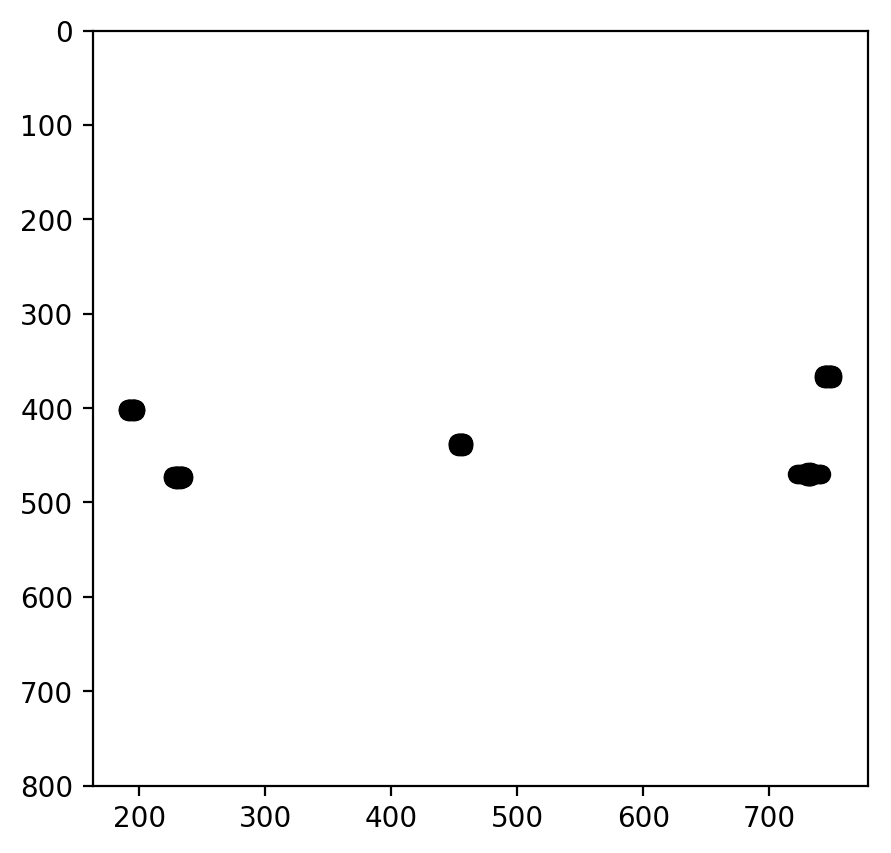

In [41]:
batch_sz = 2
img_h = 256
img_w = 306

visualize()

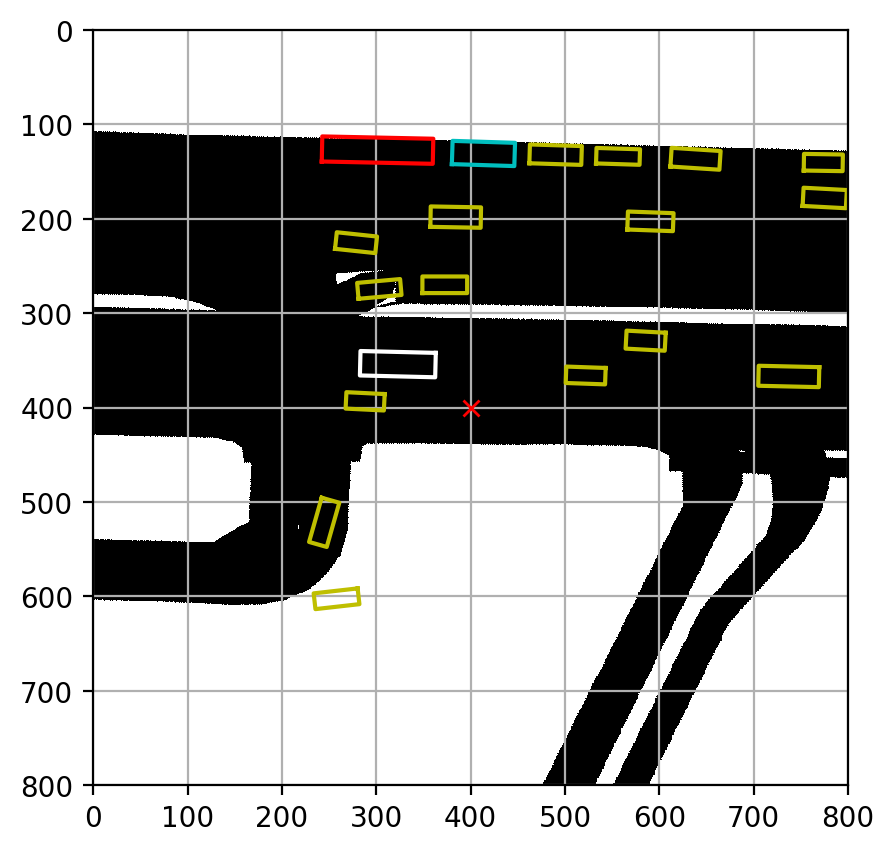

In [43]:

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

cnt = 0
for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])
    #draw_point(ax, bb, cnt, color='r')
    cnt += 1
    
    
ax.grid()